Currently evaluating -------------------------------:
Monday, 07. October 2024 08:15PM
CPUs: 14, GPUs: 1 on LAPTOP-HS456NH3.
GPU : NVIDIA GeForce RTX 2050


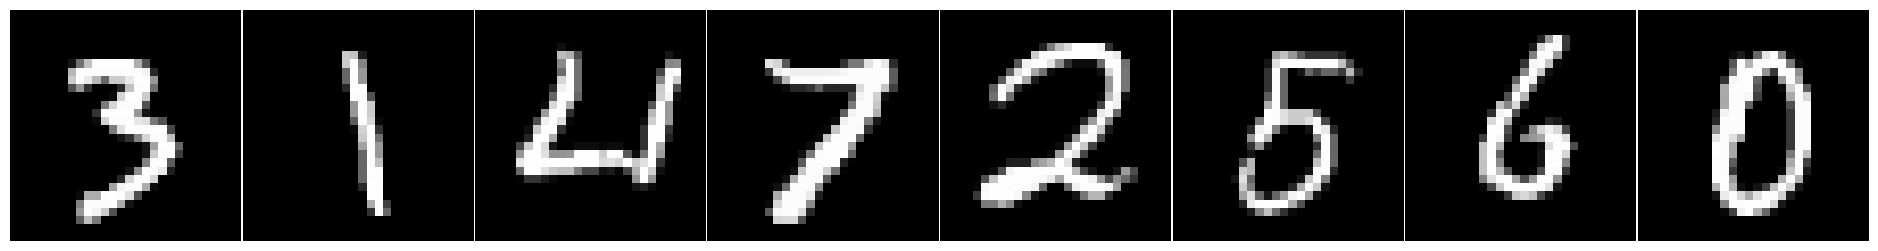

['3 - three', '1 - one', '4 - four', '7 - seven', '2 - two', '5 - five', '6 - six', '0 - zero']


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from defense import defended_gradients
from PIL import Image
import torch.nn as nn
class SimpleConvNet(nn.Module):
    """Simplified ConvNet for MNIST."""

    def __init__(self, num_classes=10, num_channels=1):
        """Initialize with number of classes and input channels."""
        super(SimpleConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # 28x28 -> 14x14
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 14x14 -> 14x14
            nn.LeakyReLU(),
            nn.MaxPool2d(2)  # 14x14 -> 7x7
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # Flatten to a 1D vector
            nn.Linear(64 * 7 * 7, 32),  # Fully connected layer
            nn.LeakyReLU(),
            nn.Linear(32, num_classes)  # Output layer for 10 classes
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
arch = 'ConvNet32'#'ResNet20'#
num_images = 8
trained_model = False
idx=30

import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('MNIST', defs)

model=SimpleConvNet()
model.to(**setup)
if trained_model:
    epochs = 120
    file = f'{arch}_{epochs}.pth'
    try:
        model.load_state_dict(torch.load(f'models/{file}'))
    except FileNotFoundError:
        inversefed.train(model, loss_fn, trainloader, validloader, defs, setup=setup)
        torch.save(model.state_dict(), f'models/{file}')
model.eval();
    
dm = torch.as_tensor(0.1307, **setup)[None, None, None]  # Mean of MNIST
ds = torch.as_tensor(0.3081, **setup)[None, None, None]  # Std of MNIST

def plot(tensor, filepath=None, title=None):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)

    if tensor.shape[0] == 1:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(tensor[0].squeeze(0).cpu(), cmap='gray')  # Display grayscale images with colormap
        ax.axis('off')
    else:
        # Set the figure size based on the number of images and their size
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(tensor.shape[0] * 3, 3))
        if tensor.shape[0] == 1:
            axes = [axes]  # make axes iterable
        for i, im in enumerate(tensor):
            axes[i].imshow(im[0].cpu(), cmap='gray')  # Display each grayscale image
            axes[i].axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)

    if title is not None:
        plt.title(title)

    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0)

    plt.show()
    
    
if num_images == 1:
    ground_truth_image = torch.as_tensor(np.array(Image.open("auto.jpg").resize((32, 32), Image.BICUBIC)) / 255, 
                                         **setup)
    ground_truth = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
    labels = torch.as_tensor((1,), device=setup['device'])
else:
    ground_truth, labels = [], []
    # idx = 30 # choosen randomly ... just whatever you want
    while len(labels) < num_images:
        img, label = validloader.dataset[idx]
        idx += 1
        if label not in labels:
            labels.append(torch.as_tensor((label,), device=setup['device']))
            ground_truth.append(img.to(**setup))
    ground_truth = torch.stack(ground_truth)
    labels = torch.cat(labels)
    
plot(ground_truth);
print([validloader.dataset.classes[l] for l in labels]);

In [4]:
#idx_start chooses images with different types. Fix that next time.
defense='dpsgd'
not_unique_labels=True
clipping_threshold=1
num_images = 16
for noise_scale in [2e-3,5e-3,2e-2,5e-2]:
    for idx_start in [1,17,33,49]:
        for num_samples in [10]: #Num samples for random sketching
            for defense_type in ['ours','default']:
                idx=idx_start
                torch.manual_seed(0)
                model = SimpleConvNet()
                model.to(**setup)
                model.eval()


                if num_images == 1:
                    ground_truth_image = torch.as_tensor(np.array(Image.open("auto.jpg").resize((32, 32), Image.BICUBIC)) / 255, 
                                                         **setup)
                    ground_truth = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
                    labels = torch.as_tensor((1,), device=setup['device'])
                else:
                    ground_truth, labels = [], []
                    # idx = 30 # choosen randomly ... just whatever you want
                    while len(labels) < num_images:
                        img, label = validloader.dataset[idx]
                        idx += 1
                        if (label not in labels) or not_unique_labels:
                            labels.append(torch.as_tensor((label,), device=setup['device']))
                            ground_truth.append(img.to(**setup))
                    ground_truth = torch.stack(ground_truth)
                    labels = torch.cat(labels)

                # if noise_scale==1e-4 and defense_type=='ours':
                #     continue
                print(f'\n\n\n\n___^^^___noise_scale:{noise_scale}, defense_method:{defense_type}, num_samples:{num_samples}___^^^___')
                model.zero_grad()
                target_loss, _, _ = loss_fn(model(ground_truth), labels)
                input_gradient = torch.autograd.grad(target_loss, model.parameters())
                input_gradient = [grad.detach() for grad in input_gradient]

                model.zero_grad()
                input_gradient = defended_gradients(model,ground_truth,labels,lambda x,y: loss_fn(x,y)[0],
                                                    noise_scale=noise_scale,
                                                    defense=defense,
                                                    defense_type=defense_type,
                                                    num_samples=num_samples,
                                                    layerwise=False,
                                                    clipping_threshold=clipping_threshold)
                
                config = dict(signed=True,
                              boxed=True,
                              cost_fn='sim', #l1,l2,max,sim,local default=sim
                              indices='def',
                              weights='equal',
                              lr=0.2,
                              optim='adam', #adam,sgd,LBFGS
                              restarts=1,
                              max_iterations=2000,
                              total_variation=1e-6,
                              init='randn',
                              filter='none',
                              lr_decay=True,
                              scoring_choice='loss')

                torch.manual_seed(0) #To Enforce same starting point

                rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=num_images)
                output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(1, 28, 28))

                test_mse = (output.detach() - ground_truth).pow(2).mean()
                feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
                test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

                with open('data.txt', 'a') as file:
                    file.write(f"loss: {stats['opt']:2.4f}, MSE: {test_mse:2.4f}, PSNR: {test_psnr:4.2f}, FMSE: {feat_mse:2.4e}, k: {noise_scale}, Defense type: {defense_type}, Num_Samples: {num_samples}, Defense: {defense}, idx: {idx_start}\n")






___^^^___noise_scale:0.002, defense_method:ours, num_samples:10___^^^___
It: 0. Rec. loss: 0.5205.
It: 500. Rec. loss: 0.1189.
It: 1000. Rec. loss: 0.1161.
It: 1500. Rec. loss: 0.1205.
It: 1999. Rec. loss: 0.1006.
Choosing optimal result ...
Optimal result score: 0.1071
Total time: 11.699361562728882.




___^^^___noise_scale:0.002, defense_method:default, num_samples:10___^^^___
It: 0. Rec. loss: 0.5226.
It: 500. Rec. loss: 0.1212.
It: 1000. Rec. loss: 0.1367.
It: 1500. Rec. loss: 0.1604.
It: 1999. Rec. loss: 0.1647.
Choosing optimal result ...
Optimal result score: 0.1829
Total time: 18.76022982597351.




___^^^___noise_scale:0.002, defense_method:ours, num_samples:10___^^^___
It: 0. Rec. loss: 0.5791.
It: 500. Rec. loss: 0.1735.
It: 1000. Rec. loss: 0.1810.
It: 1500. Rec. loss: 0.1807.
It: 1999. Rec. loss: 0.1567.
Choosing optimal result ...
Optimal result score: 0.1562
Total time: 11.380808591842651.




___^^^___noise_scale:0.002, defense_method:default, num_samples:10___^^^_

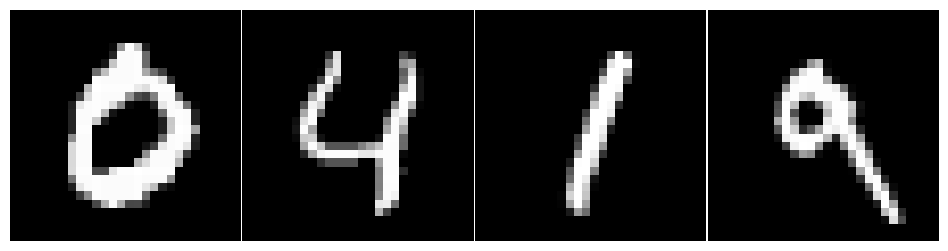

It: 0. Rec. loss: 0.5902.
It: 500. Rec. loss: 0.0842.
It: 1000. Rec. loss: 0.0795.
It: 1500. Rec. loss: 0.0754.
It: 1999. Rec. loss: 0.0752.
Choosing optimal result ...
Optimal result score: 0.0542
Total time: 10.929415464401245.


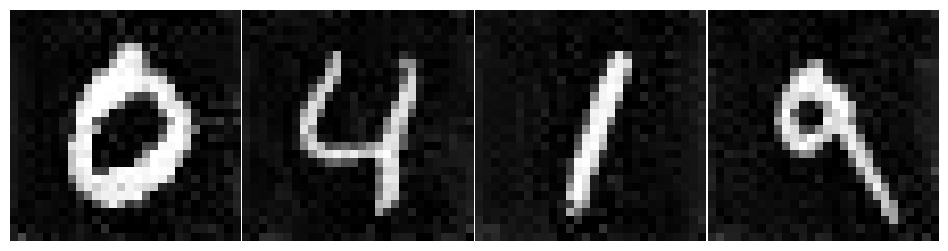

Rec. loss: 0.0542 | MSE: 0.0495 | PSNR: 23.29 | FMSE: 3.2832e-04 |


In [22]:
torch.manual_seed(0)
model=SimpleConvNet()
model.to('cuda')
model.eval()
idx=3
num_images=4
not_unique_labels=False
if num_images == 1:
    ground_truth_image = torch.as_tensor(np.array(Image.open("auto.jpg").resize((32, 32), Image.BICUBIC)) / 255, 
                                         **setup)
    ground_truth = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
    labels = torch.as_tensor((1,), device=setup['device'])
else:
    ground_truth, labels = [], []
    # idx = 30 # choosen randomly ... just whatever you want
    while len(labels) < num_images:
        img, label = validloader.dataset[idx]
        idx += 1
        if (label not in labels) or not_unique_labels:
            labels.append(torch.as_tensor((label,), device=setup['device']))
            ground_truth.append(img.to(**setup))
    ground_truth = torch.stack(ground_truth)
    labels = torch.cat(labels)
    
plot(ground_truth,'plots/mnist_ground_truth.pdf')

model.zero_grad()
model.eval()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

model.zero_grad()
input_gradient = defended_gradients(model,ground_truth,labels,lambda x,y: loss_fn(x,y)[0],
                                    noise_scale=0.8,
                                    defense='prune',
                                    defense_type='default',
                                    num_samples=10,
                                    layerwise=False,
                                    clipping_threshold=1)


config = dict(signed=True,
              boxed=True,
              cost_fn='sim', #l1,l2,max,sim,local default=sim
              indices='def',
              weights='equal',
              lr=0.2,
              optim='adam', #adam,sgd,LBFGS
              restarts=1,
              max_iterations=2000,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

torch.manual_seed(0)#To Enforce same starting point

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=num_images)
output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(1, 28, 28))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

plot(output,filepath='plots/mnist_prune_default_0.8.pdf')

print(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} | PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |")